In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings
import math

from copy import deepcopy
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, QueryByCommittee, RandomSampling, BatchBALD, DiscriminativeAL, GreedySamplingX, GreedySamplingTarget, QueryByCommittee, \
    KLDivergenceMaximization, ExpectedModelChangeMaximization
from skactiveml.utils import call_func, unlabeled_indices
from sklearn.datasets import fetch_openml
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from tqdm import tqdm
import matplotlib.colors as mcolors

In [2]:
mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -5
RANDOM_STATE = 0
FONTSIZE = 12

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.deterministic = True

warnings.filterwarnings("ignore")

# 1. Classification

In [3]:
def spiral_xy(i, total_points, spiral_num, n_shape = 50):
    """
    Create the data for a normalized spiral.

    Arguments:
        i runs from 0 to total_points-1.
        total_points is the total number of points in the spiral.
        spiral_num is 1 or -1.
        n_shape is an int which determines the shape of spiral wrt function, unscaled_spiral_xy.
    """
    # Normalize i to always fit in the range [0, 96], which is the original range.
    i_normalized = i * n_shape / (total_points - 1)
    φ = i_normalized / 16 * math.pi
    r = 6.5 * ((104 - i_normalized) / 104)
    x = (r * math.cos(φ) * spiral_num) / 13 + 0.5
    y = (r * math.sin(φ) * spiral_num) / 13 + 0.5  # spiral_num mirrors the orientation of the spiral
    return (x, y)


def spiral(spiral_num, n=100, n_shape = 50):
    """
    Generate either a clockwise (+1) spiral or a counter clockwise (-1) spiral for a total of n points.

    Arguments:
        spiral_num: 1 or -1 determines the orientation of the spiral.
        n: total number of points in a spiral.
    """
    return [spiral_xy(i, n, spiral_num, n_shape) for i in range(n//2)]


def generate_spiral_data(n=100, n_train = 80, n_shape = 50, seed = RANDOM_STATE, default_label = True):
    """
    Generate binary spiral classification data.

    Arguments:
        n: total number of points in a spiral.
        n_train: numbr of training points.
        seed: permutation randomization seed.
        default_label: True uses label +/-1 and False uses label 0/1
    """
    a = spiral(1,n,n_shape)
    b = spiral(-1,n,n_shape)
    # Combine spiral from both orientation as one and scaling feature space from (0,1)^2 to (-1,1)^2
    X_all=2*np.concatenate((a,b),axis=0)-1 
    X_all=np.append(X_all,np.ones((n,1)),axis=1) # Adding bias to the feature space
    # concatenate the labels of the spiral, which is their orientation (+1/-1)
    if default_label:
        y_all=np.concatenate((np.ones(n//2),-np.ones(n//2))) 
    else:
        y_all=np.concatenate((np.ones(n//2),np.zeros(n//2))) # reset -1 to 0.
    # randomize data indices
    np.random.seed(seed)
    idx = np.random.permutation(n)
    X_all = X_all[idx]
    y_all = y_all[idx]
    # Split into training and testing sets
    X_train, y_train = X_all[:n_train], y_all[:n_train]
    X_test, y_test = X_all[n_train:], y_all[n_train:]
    
    return X_all, y_all, X_train, y_train, X_test, y_test

In [4]:
X_all, y_all, X_train, y_train, X_test, y_test = generate_spiral_data(seed = RANDOM_STATE, default_label = False)

In [5]:
# Convert data to float32 as required by PyTorch
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

In [6]:
classes = np.unique(y_train)

In [7]:
# sanity check
print(X_train.shape,y_train.shape, np.unique(y_train))

(80, 3) (80,) [0 1]


In [8]:
class ClassifierModule(nn.Module):
    def __init__(self, n_classes=2, dropout=0.5):
        super(ClassifierModule, self).__init__()
        self.fc1 = nn.Linear(3, 623)  # Input is 3-dimensional (x, y, bias)
        self.fc3 = nn.Linear(623, n_classes)  # Output is 2 classes (binary classification)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)  # Dropout applied only during training
        x = self.fc3(x)
        return x

In [9]:
# create initial estimators
estimators = []
for i in range(5):
    # Initialize the NeuralNetClassifier with skorch
    net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=2000,
    lr=0.001,
    verbose=False,
    criterion = torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.9,
    optimizer__weight_decay=3e-3,
    batch_size=16,
    iterator_train__shuffle=True,  # Shuffle with the seed fixed
    train_split=None)  # Disable internal validation split)

    net.initialize()
    clf = SklearnClassifier(
        estimator=net,
        missing_label=MISSING_LABEL,
        random_state=i,
        classes=classes,
    )
    estimators.append((f'clf {i}', clf))

# Creat voting ensemble out of given ensemble list.
ensemble_init = SklearnClassifier(
    estimator=VotingClassifier(estimators=estimators, voting='soft'),
    missing_label=MISSING_LABEL,
    random_state=RANDOM_STATE,
    classes=classes,
)

In [10]:
def scikit_activeml_clf(n_cycles,X_all,y_all,X_train,y_train,X_test,y_test,strategy, estimators, seed = RANDOM_STATE, plot = False):
    # output is test/train accuracy rate, final ensemble, and chosen indices
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)
    
    if strategy == 'greedyX':
        qs = GreedySamplingX(random_state=RANDOM_STATE, missing_label=MISSING_LABEL)
    elif strategy == 'qbc':
        qs = QueryByCommittee(random_state=RANDOM_STATE, missing_label=MISSING_LABEL)
    
   
    ensemble = deepcopy(ensemble_init)

    # Create array of missing labels as initial labels.
    y = np.full_like(y_train, fill_value=MISSING_LABEL, dtype=np.int64)
    X = X_train

    # Label one sample from each class for warm start. No warm start
    # for i in range(2):
    #     y[np.argwhere(y_train==i)[0]] = i
    
    
    queries = []

    # Execute active learning cycle.
    for c in tqdm(range(n_cycles)):
        # Fit and evaluate ensemble.
        ensemble.fit(X, y) # base model
        # test_acc = ensemble.score(X_test, y_test)
        # train_acc = ensemble.score(X_train, y_train)
        # train_acc_dict[qs_name][c] = train_acc

        # Select and update training data.
        query_idx = call_func(
            qs.query,
            X=X,
            y=y,
            clf=ensemble,
            fit_clf=False,
            ensemble=ensemble,
            fit_ensemble=False,
            batch_size=1,
        )
        # query_idx = ulbd_indices[query_idx]
        y[query_idx] = y_train[query_idx]
        queries.append(query_idx)

    # Fit and evaluate ensemble after queries.
    ensemble.fit(X, y)
    test_acc = ensemble.score(X_test, y_test)
    train_acc = ensemble.score(X_train, y_train)
    
    if plot:
        # Plot decision boundary
        x_min, x_max = -1, 1
        y_min, y_max = -1, 1

        # Create a grid of points
        x1 = np.linspace(x_min, x_max, 100)
        x2 = np.linspace(y_min, y_max, 100)
        x1, x2 = np.meshgrid(x1, x2)
        Xtest = np.c_[x1.ravel(), x2.ravel()]
        Xtest = np.append(Xtest, np.ones((Xtest.shape[0], 1)), axis=1)  # Add the bias term
        Xtest = Xtest.astype(np.float32)
        # print(len(Xtest))
        yest = ensemble.predict(Xtest)
        # print(len(yest))
        yest = yest.reshape(x1.shape)

        # Create subplots
        fig, ax = plt.subplots(figsize=(7, 7))

        # Define the custom colors
        colors = ['#920783', '#00b7c7']  # Switched the colors to match the image
        cmap = mcolors.ListedColormap(colors)

        # Plot the decision boundary with custom colors
        ax.contourf(x1, x2, yest, alpha=0.3, cmap=cmap)
        scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', s=20, cmap=cmap)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        plt.show()
        
    return test_acc, train_acc, ensemble, queries

In [11]:
itr_ls = np.arange(0,55,5)
itr_ls[0] = 1
itr_ls

array([ 1,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [12]:
test_acc_greedy = []
train_acc_greedy = []
test_acc_qbc = []
train_acc_qbc = []
for i in itr_ls:
    test_acc, train_acc, ensemble, queries = scikit_activeml_clf(i,X_all,y_all,X_train,y_train,X_test,y_test,'greedyX', 623, RANDOM_STATE, False)
    test_acc_greedy.append(test_acc)
    train_acc_greedy.append(train_acc)
    test_acc, train_acc, ensemble, queries = scikit_activeml_clf(i,X_all,y_all,X_train,y_train,X_test,y_test,'qbc', 623, RANDOM_STATE, False)
    test_acc_qbc.append(test_acc)
    train_acc_qbc.append(train_acc)
    print(i)

100%|██████████| 1/1 [00:00<00:00, 108.63it/s]


1


100%|██████████| 5/5 [00:45<00:00,  9.16s/it]


5


100%|██████████| 10/10 [01:55<00:00, 11.57s/it]


10


100%|██████████| 15/15 [03:14<00:00, 12.96s/it]


15


100%|██████████| 20/20 [05:03<00:00, 15.19s/it]


20


100%|██████████| 25/25 [07:13<00:00, 17.35s/it]


25


100%|██████████| 30/30 [09:38<00:00, 19.30s/it]


30


100%|██████████| 35/35 [12:50<00:00, 22.01s/it]


35


100%|██████████| 40/40 [16:49<00:00, 25.23s/it]


40


100%|██████████| 45/45 [20:20<00:00, 27.12s/it]


45


100%|██████████| 50/50 [22:34<00:00, 27.08s/it]


50


In [13]:
import pickle # for saving lists

In [14]:
with open(f'acc_greedyX_test50_seed0.pkl', 'wb') as f:
    pickle.dump(test_acc_greedy, f)

with open(f'acc_greedyX_train50_seed0.pkl', 'wb') as f:
    pickle.dump(train_acc_greedy, f)
    
with open(f'acc_qbc_test50_seed0.pkl', 'wb') as f:
    pickle.dump(test_acc_qbc, f)

with open(f'acc_qbc_train50_seed0.pkl', 'wb') as f:
    pickle.dump(train_acc_qbc, f)

Execute active learning using greedyX.


100%|██████████| 15/15 [03:05<00:00, 12.39s/it]


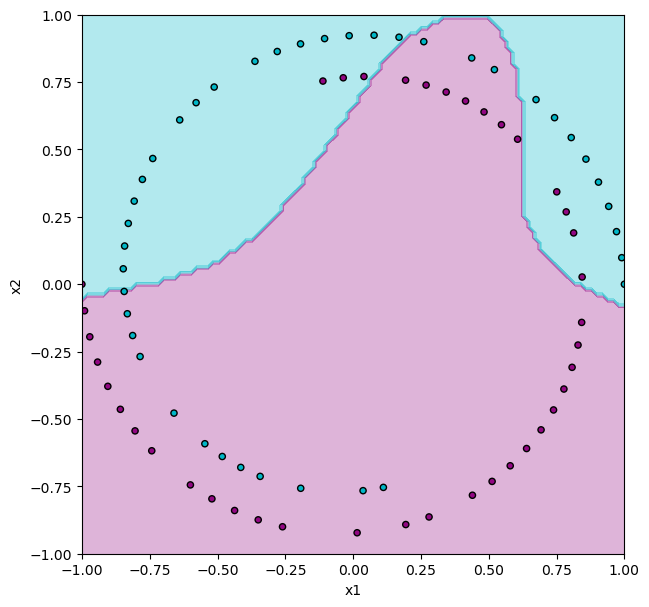

Execute active learning using qbc.


100%|██████████| 15/15 [03:06<00:00, 12.43s/it]


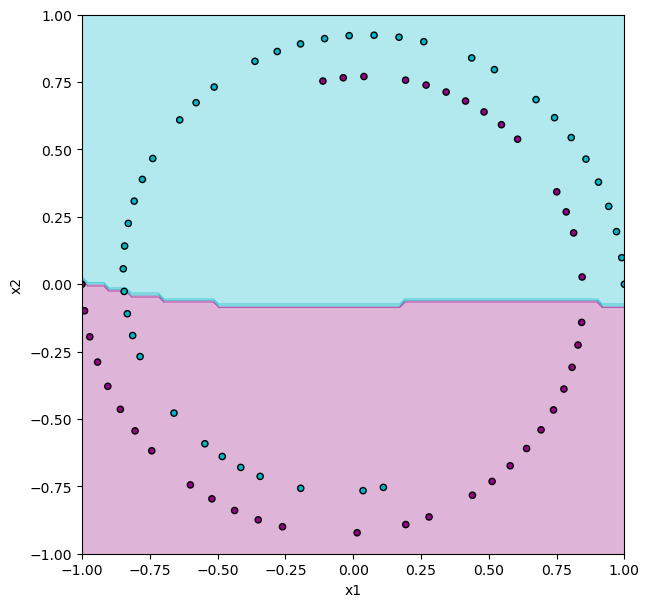

In [16]:
# Modified setup.
n_cycles = 15
batch_size = 1 # query 1 data point per step
# n_sub_set = 1000 # no subset
# qs_dict = {
#     'random sampling': RandomSampling(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
#     'uncertainty sampling': UncertaintySampling(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
#     'query-by-committee': QueryByCommittee(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
#     'batch-bald': BatchBALD(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
# }
qs_dict = {
        'greedyX': GreedySamplingX(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
        'qbc': QueryByCommittee(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
}

test_acc_dict = {key: np.zeros(n_cycles+1) for key in qs_dict}
train_acc_dict = {key: np.zeros(n_cycles+1) for key in qs_dict}

# Perform active learning with each query strategy.
for qs_name, qs in qs_dict.items():
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)

    print(f'Execute active learning using {qs_name}.')

    # Copy initial ensemble model.
    ensemble = deepcopy(ensemble_init)

    # Create array of missing labels as initial labels.
    y = np.full_like(y_train, fill_value=MISSING_LABEL, dtype=np.int64)
    X = X_train

    # Label one sample from each class for warm start. No warm start
    # for i in range(2):
    #     y[np.argwhere(y_train==i)[0]] = i

    # Execute active learning cycle.
    for c in tqdm(range(n_cycles)):
        # Fit and evaluate ensemble.
        ensemble.fit(X, y) # base model
        test_acc = ensemble.score(X_test, y_test)
        test_acc_dict[qs_name][c] = test_acc
        train_acc = ensemble.score(X_train, y_train)
        train_acc_dict[qs_name][c] = train_acc

        # ulbd_indices = np.random.choice(unlabeled_indices(y, MISSING_LABEL), n_sub_set)

        # Select and update training data.
        query_idx = call_func(
            qs.query,
            X=X,
            y=y,
            clf=ensemble,
            fit_clf=False,
            ensemble=ensemble,
            fit_ensemble=False,
            batch_size=batch_size,
        )
        # query_idx = ulbd_indices[query_idx]
        y[query_idx] = y_train[query_idx]

    # Fit and evaluate ensemble after queries.
    ensemble.fit(X, y)
    test_acc = ensemble.score(X_test, y_test)
    test_acc_dict[qs_name][c] = test_acc
    train_acc = ensemble.score(X_train, y_train)
    train_acc_dict[qs_name][c] = train_acc
        
    # Plot decision boundary
    x_min, x_max = -1, 1
    y_min, y_max = -1, 1

    # Create a grid of points
    x1 = np.linspace(x_min, x_max, 100)
    x2 = np.linspace(y_min, y_max, 100)
    x1, x2 = np.meshgrid(x1, x2)
    Xtest = np.c_[x1.ravel(), x2.ravel()]
    Xtest = np.append(Xtest, np.ones((Xtest.shape[0], 1)), axis=1)  # Add the bias term
    Xtest = Xtest.astype(np.float32)
    # print(len(Xtest))
    yest = ensemble.predict(Xtest)
    # print(len(yest))
    yest = yest.reshape(x1.shape)

    # Create subplots
    fig, ax = plt.subplots(figsize=(7, 7))

    # Define the custom colors
    colors = ['#920783', '#00b7c7']  # Switched the colors to match the image
    cmap = mcolors.ListedColormap(colors)

    # Plot the decision boundary with custom colors
    ax.contourf(x1, x2, yest, alpha=0.3, cmap=cmap)
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor='k', s=20, cmap=cmap)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    plt.show()            

In [ ]:
# visualize test accuracy
cycles = np.arange(n_cycles+1, dtype=int)
plt.figure(figsize=(16, 9))
for qs_name, acc in test_acc_dict.items():
    plt.plot(cycles, acc, label=f'{qs_name}: AULC={round(acc.mean(), 2)}')
plt.xticks(cycles, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('# cycle', fontsize=FONTSIZE)
plt.ylabel('test accuracy', fontsize=FONTSIZE)
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

In [ ]:
# visualize test accuracy
cycles = np.arange(n_cycles+1, dtype=int)
plt.figure(figsize=(16, 9))
for qs_name, acc in train_acc_dict.items():
    plt.plot(cycles, acc, label=f'{qs_name}: AULC={round(acc.mean(), 2)}')
plt.xticks(cycles, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('# cycle', fontsize=FONTSIZE)
plt.ylabel('train accuracy', fontsize=FONTSIZE)
plt.legend(loc='lower right', fontsize='x-large')
plt.show()

# 2. Regression

In [ ]:
# data generationn
def generate_quadratic_regression(n = 100, n_train = 80, seed = 0, noise = False, noise_param = 0.05, plot = True):
    x_vals = np.linspace(-1, 1, n)  # Generate n points uniformly spaced between -1 and 1
    y_true = x_vals ** 2  # Calculate y = x^2
    
    # Add some noise to make it a more realistic regression problem
    if noise:
        noise = noise_param * np.random.randn(n)
        y_vals = y_vals + noise
    else:
        y_vals = y_true
    
    # Plot the generated data
    if plot:
        plt.figure(figsize=(7, 7))
        plt.scatter(x_vals, y_true, color='blue', label='Data Points')
        plt.plot(x_vals, y_vals, color='black', label='True y = x^2', linewidth=2)
        
        plt.title('Continuous Quadratic Regression Dataset')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
    else:
        pass

    # Adding bias to the data
    X_all = np.column_stack((x_vals, np.ones(n)))  # Shape: (n, 2) where the second column is the bias term
    y_all = y_vals # y_all is unchanged

    # randomly select X,y
    np.random.seed(seed)
    
    # Randomly select 80 indices
    selected_indices = np.random.choice(np.arange(n), size=n_train, replace=False)
    unselected_indices = np.setdiff1d(np.arange(n), selected_indices)
    
    # Select the corresponding rows from X and values from Y for train dataset
    X = X_all[selected_indices]
    y = y_all[selected_indices]
    
    # Test set
    X_test = X_all[unselected_indices]
    y_test = y_all[unselected_indices]

    return X_all, y_all, X, y, X_test, y_test

In [ ]:
X_all, y_all, X_train, y_train, X_test, y_test = generate_quadratic_regression(seed = RANDOM_STATE)

In [ ]:
# Convert data to float32 as required by PyTorch
X_all = X_all.astype(np.float32)
y_all = y_all.astype(np.float32)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(self, n_classes=1):
        super(ClassifierModule, self).__init__()
        self.fc1 = nn.Linear(2, 160) 
        self.fc3 = nn.Linear(160, n_classes) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)  # Dropout applied only during training
        x = self.fc3(x)
        return x

In [ ]:
from skorch import NeuralNetRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from skactiveml.regressor import SklearnRegressor, NICKernelRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
class SklearnRegressorFixed(SklearnRegressor):
    def predict(self, X):
        predictions = super().predict(X)
        # Flatten the output if it's 2D (n_samples, 1) to (n_samples,)
        if predictions.ndim > 1:
            predictions = predictions.ravel()
        return predictions

In [ ]:
# create initial estimators
estimators = []
for i in range(5):
    # Initialize the NeuralNetRegressor with skorch
    net = NeuralNetRegressor(
        ClassifierModule, 
        max_epochs=2000,
        lr=0.001,
        verbose=False,
        optimizer=torch.optim.SGD,
        optimizer__momentum=0.9,
        optimizer__weight_decay=3e-3,
        batch_size=16,
        iterator_train__shuffle=True,  # Shuffle with the seed fixed
        train_split=None  # Disable internal validation split
    )

    net.initialize()
    reg = SklearnRegressorFixed( 
        estimator=net,
        missing_label=MISSING_LABEL,
        random_state=i,
    )
    estimators.append((f'reg {i}', reg))

# Create voting ensemble out of the regressor estimators.
# ensemble_init = VotingRegressor(estimators=estimators)

ensemble_init = SklearnRegressor(
    estimator=VotingRegressor(estimators=estimators),
    missing_label=MISSING_LABEL,
    random_state=RANDOM_STATE,
)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# Modified setup.
n_cycles = 10
batch_size = 1 # query 1 data point per step

qs_dict = {
        'greedyX': GreedySamplingX(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
        'greedyTarget': GreedySamplingTarget(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
        'qbc': QueryByCommittee(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
        # 'kldiv': KLDivergenceMaximization(
        #     random_state=RANDOM_STATE, missing_label=MISSING_LABEL,
        #     integration_dict_target_val={
        #         "method": "assume_linear",
        #         "n_integration_samples": 3,
        #     },
        #     integration_dict_cross_entropy={
        #         "method": "assume_linear",
        #         "n_integration_samples": 3,
        #     }
        # )
        'emc': ExpectedModelChangeMaximization(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
  
}

test_acc_dict = {key: np.zeros(n_cycles+1) for key in qs_dict}
train_acc_dict = {key: np.zeros(n_cycles+1) for key in qs_dict}

# Perform active learning with each query strategy.
for qs_name, qs in qs_dict.items():
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)

    print(f'Execute active learning using {qs_name}.')

    # Copy initial ensemble model.
    ensemble = deepcopy(ensemble_init)

    y = np.full_like(y_train, fill_value=MISSING_LABEL, dtype=np.float32)
    X = X_train
    
    X_selected = []
    y_selected = []

    # Execute active learning cycle.
    for c in tqdm(range(n_cycles)):
        # Fit and evaluate ensemble.
        ensemble.fit(X, y) # base model
        test_acc = mean_squared_error(y_test, ensemble.predict(X_test))
        test_acc_dict[qs_name][c] = test_acc
        train_acc = mean_squared_error(y_train, ensemble.predict(X_train))
        train_acc_dict[qs_name][c] = train_acc

        # Select and update training data.
        query_idx = call_func(
            qs.query,
            X=X,
            y=y,
            reg=ensemble,
            fit_reg=False,
            ensemble=ensemble,
            fit_ensemble=False,
            batch_size=batch_size,
        )
        
        query_idx = query_idx[0]
        y[query_idx] = y_train[query_idx]
        xs = X_train[query_idx]
        X_selected.append(xs[0])
        # print(X_selected)
        y_selected.append(y_train[query_idx])

    # Fit and evaluate ensemble.
    ensemble.fit(X,y)
    test_acc = mean_squared_error(y_test, ensemble.predict(X_test))
    test_acc_dict[qs_name][c] = test_acc
    train_acc = mean_squared_error(y_train, ensemble.predict(X_train))
    train_acc_dict[qs_name][c] = train_acc
    
    # prediction
    y_pred = ensemble.predict(X_all)
        
    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(X_all[:,:-1].ravel(), y_all, 'k-', label='True y = x^2')
    plt.scatter(X_selected, y_selected, color='blue', label=f'Queried Points ({qs_name})', s=50)
    # plot test points
    plt.scatter(X_test[:,:-1].ravel(), y_test, color='red', label='Test Data', alpha=0.5, marker='x')
    plt.plot(X_all[:,:-1].ravel(), y_pred, label=f'Prediction ({qs_name})', linewidth=2)
    #plt.fill_between(X_all[:,:-1].ravel(), y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, color='lightblue', alpha=0.3, label='95% Confidence Interval')
    plt.title(f'Active Learning ({qs_name})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(f'{qs_name}.pdf', bbox_inches='tight')
    plt.show()